In [20]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS, WS_B
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

import tensorflow

tensorflow.config.list_physical_devices('GPU')
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:    # Restrict TensorFlow to only allocate memory on the GPU dynamically
    for gpu in gpus:
        tensorflow.config.experimental.set_memory_growth(gpu, True)
    tensorflow.config.experimental.set_visible_devices(gpus[0], 'GPU')

from tensorflow.keras.models        import Sequential, Model, load_model
from tensorflow.keras.initializers  import GlorotUniform
from tensorflow.keras.layers        import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers        import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers        import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers        import concatenate, Concatenate
from tensorflow.keras.optimizers    import Adam
from tensorflow.keras.losses        import BinaryCrossentropy
from tensorflow.keras.metrics       import AUC, Precision, Recall

from tensorflow.keras.utils         import plot_model


folder_path = '/home/rl_sim/thesis_ws/src/RobotData_GRIPA320'
data_folder = '/home/rl_sim/thesis_ws/src/ML/DATA/1D_F_GRIP/'

In [21]:
def load_data(data_folder):
    X_data = []
    y_data = []
    # Get list of all .npz files in the data folder
    npz_files = [file for file in os.listdir(data_folder) if file.endswith('.npz')]
    
    # Load data from each .npz file
    for file in npz_files:
        file_path = os.path.join(data_folder, file)
        data = np.load(file_path)
        X_data.append(data['X'])  # Assuming X_data is stored under 'X' key in the .npz file
        y_data.append(data['y'])  # Assuming y_data is stored under 'y' key in the .npz file
        data.close()
    
    # Convert lists to NumPy arrays
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

X_data shape: (1248, 800)
y_data shape: (1248,)
X_data.[0] shape:  (800,)


In [22]:
TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

TOTAL DATA: 1248  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (748, 800)    ||  Dimensions of y_train: (748,)
Dimensions of X_test:  (250, 800)    ||  Dimensions of y_test:  (250,)
Dimensions of X_val:   (250, 800)    ||  Dimensions of y_val:   (250,)


# EAIEST FF-ANN

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,849 (870.50 KB)

 Trainable params: 222,209 (868.00 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6266 - loss: 0.6787 - val_accuracy: 0.6160 - val_loss: 0.7930
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6871 - loss: 0.5612 - val_accuracy: 0.6800 - val_loss: 0.5977
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7043 - loss: 0.5633 - val_accuracy: 0.7000 - val_loss: 0.5730
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7597 - loss: 0.5081 - val_accuracy: 0.7560 - val_loss: 0.5055
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7502 - loss: 0.4791 - val_accuracy: 0.7000 - val_loss: 0.5974
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7737 - loss: 0.4872 - val_accuracy: 0.7840 - val_loss: 0.5218
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8030 - loss: 0.4556 - val_accuracy: 0.7840 - val_loss: 0.5119
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8139 - loss: 0.4110 - val_accuracy: 0.7440 - val_loss

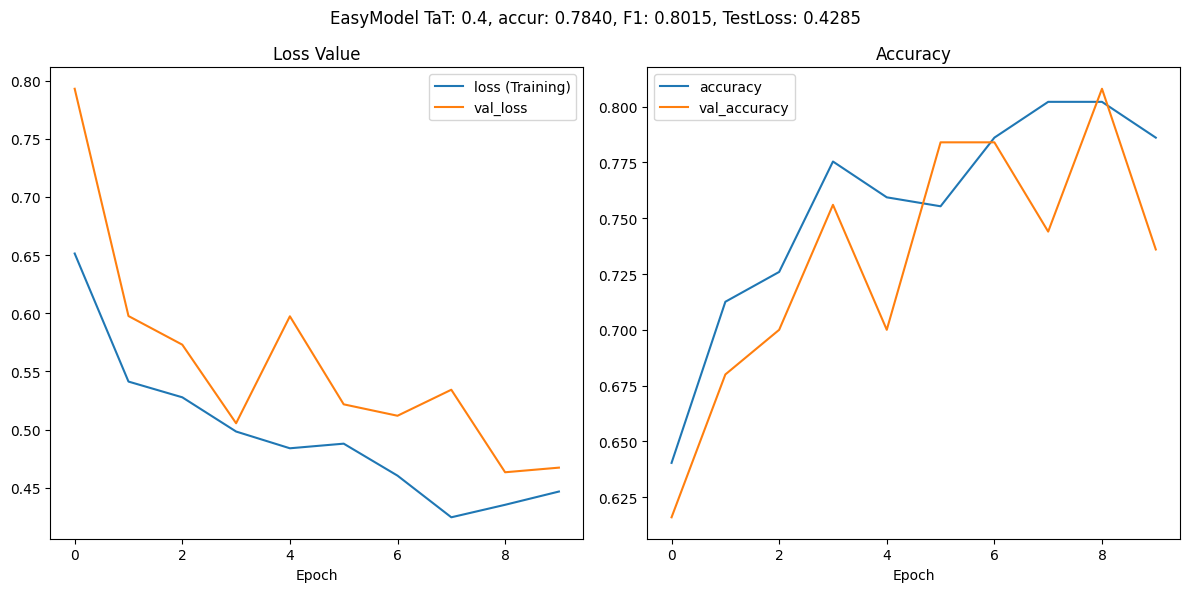

Train loss: 0.44679757952690125
Test val_loss: 0.4673355519771576
Train accuracy: 0.7860962748527527
Accuracy Score: 0.784
F1 Score: 0.8014705882352942
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.67      0.76       129
         1.0       0.72      0.90      0.80       121

    accuracy                           0.78       250
   macro avg       0.80      0.79      0.78       250
weighted avg       0.80      0.78      0.78       250



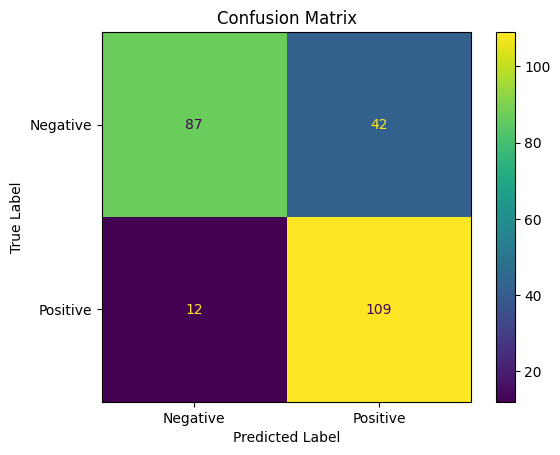

In [23]:
def build_ff_ann():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(800,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    return model

model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1) # , callbacks=[tensorboard]

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8813 - loss: 0.4415 - val_auc: 0.8666 - val_loss: 0.5753
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9004 - loss: 0.4121 - val_auc: 0.7851 - val_loss: 0.7886
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9255 - loss: 0.3524 - val_auc: 0.8775 - val_loss: 0.4993
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9204 - loss: 0.3667 - val_auc: 0.8731 - val_loss: 0.4806
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9113 - loss: 0.3815 - val_auc: 0.8861 - val_loss: 0.4344
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8782 - loss: 0.4381 - val_auc: 0.8508 - val_loss: 0.6009
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9145 - loss: 0.3657 - val_auc: 0.8577 - val_loss: 0.5319
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8992 - loss: 0.4041 - val_auc: 0.8704 - val_loss: 0.5217
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8990 - loss:

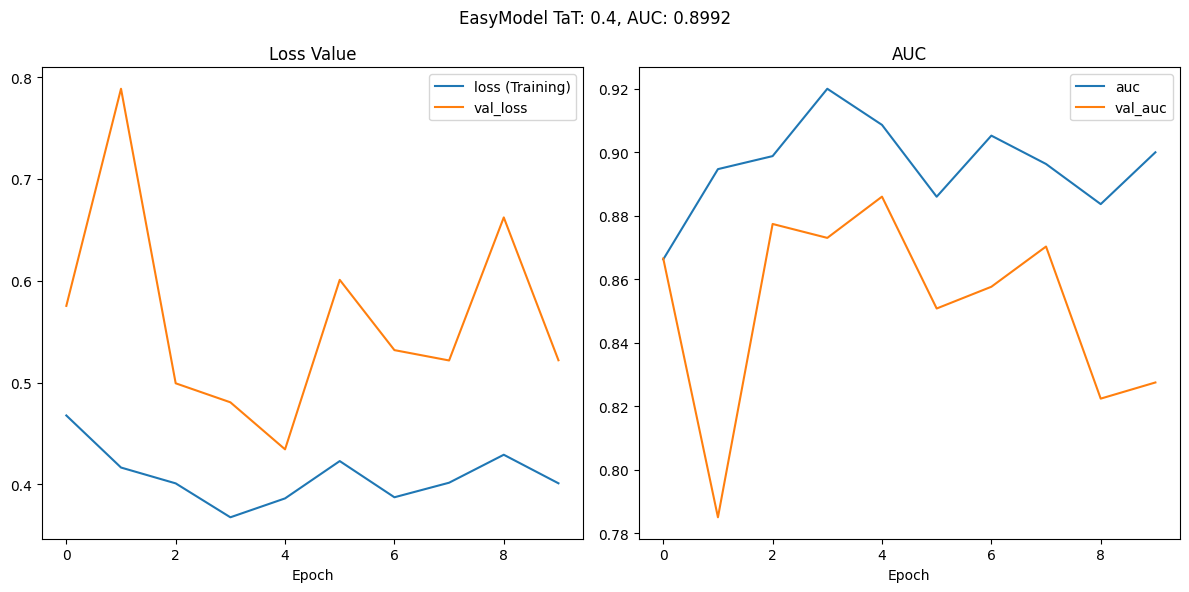

Train loss: 0.40107008814811707
Test val_loss: 0.5219183564186096
AUC: 0.8991607405983727
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.87      0.82       129
         1.0       0.84      0.74      0.79       121

    accuracy                           0.81       250
   macro avg       0.81      0.81      0.81       250
weighted avg       0.81      0.81      0.81       250



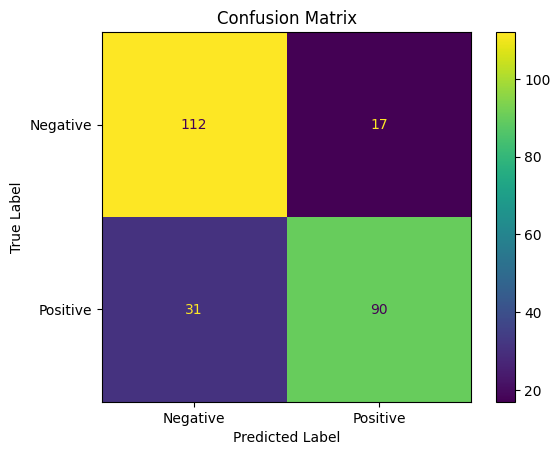

In [24]:
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['auc'])  # Change metric to 'auc'
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot AUC
axs[1].plot(history.history["auc"], label="auc")
axs[1].plot(history.history["val_auc"], label="val_auc")
axs[1].set_title("AUC")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, AUC: {auc:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("AUC:", auc)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

# 'NORMAL' FF-ANN (few layers)

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,065 (969.00 KB)

 Trainable params: 247,169 (965.50 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.5743 - loss: 0.7869 - val_accuracy: 0.6400 - val_loss: 1.8140
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6717 - loss: 0.6148 - val_accuracy: 0.6920 - val_loss: 0.8762
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7235 - loss: 0.5480 - val_accuracy: 0.6600 - val_loss: 0.8122
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7094 - loss: 0.5329 - val_accuracy: 0.6800 - val_loss: 0.6396
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7344 - loss: 0.5249 - val_accuracy: 0.6840 - val_loss: 0.6006
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7898 - loss: 0.4788 - val_accuracy: 0.7280 - val_loss: 0.5551
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7863 - loss: 0.4652 - val_accuracy: 0.7800 - val_loss: 0.5496
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7571 - loss: 0.5016 - val_accuracy: 0.7280 - val_los

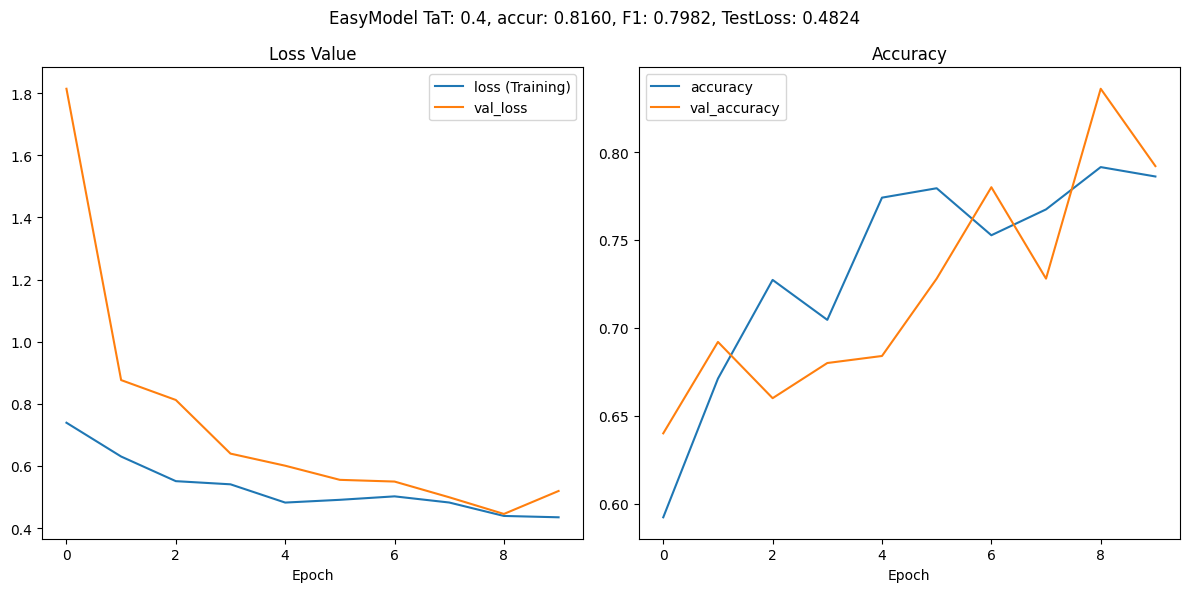

Train loss: 0.4345889687538147
Test val_loss: 0.5192964673042297
Train accuracy: 0.7860962748527527
Accuracy Score: 0.816
F1 Score: 0.7982456140350878
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.88      0.83       129
         1.0       0.85      0.75      0.80       121

    accuracy                           0.82       250
   macro avg       0.82      0.81      0.81       250
weighted avg       0.82      0.82      0.82       250



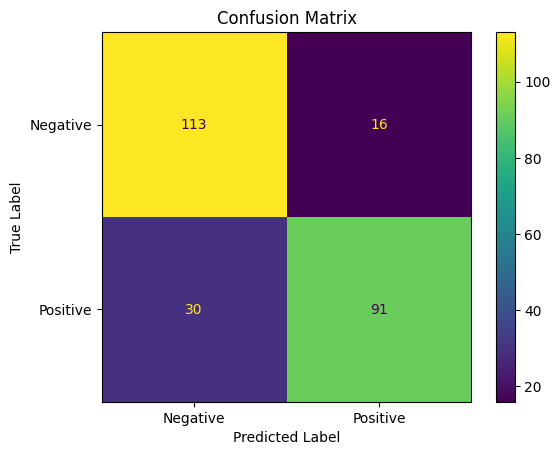

In [25]:
def build_ff_ann():
    model = Sequential()
    model.add(Dense(526, activation='relu', input_shape=(800,)))
    model.add(Dropout(0.2))  # Add dropout for regularization
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification
    return model

model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1) # , callbacks=[tensorboard]

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - auc: 0.6296 - loss: 0.8191 - val_auc: 0.6391 - val_loss: 1.0903
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7773 - loss: 0.5797 - val_auc: 0.6977 - val_loss: 0.9883
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7912 - loss: 0.5498 - val_auc: 0.7297 - val_loss: 0.8355
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8318 - loss: 0.5060 - val_auc: 0.7416 - val_loss: 0.7216
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8281 - loss: 0.4999 - val_auc: 0.7879 - val_loss: 0.5692
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8500 - loss: 0.4722 - val_auc: 0.8180 - val_loss: 0.5426
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8347 - loss: 0.4955 - val_auc: 0.7997 - val_loss: 0.7025
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8452 - loss: 0.4932 - val_auc: 0.8799 - val_loss: 0.4477
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8643 - loss

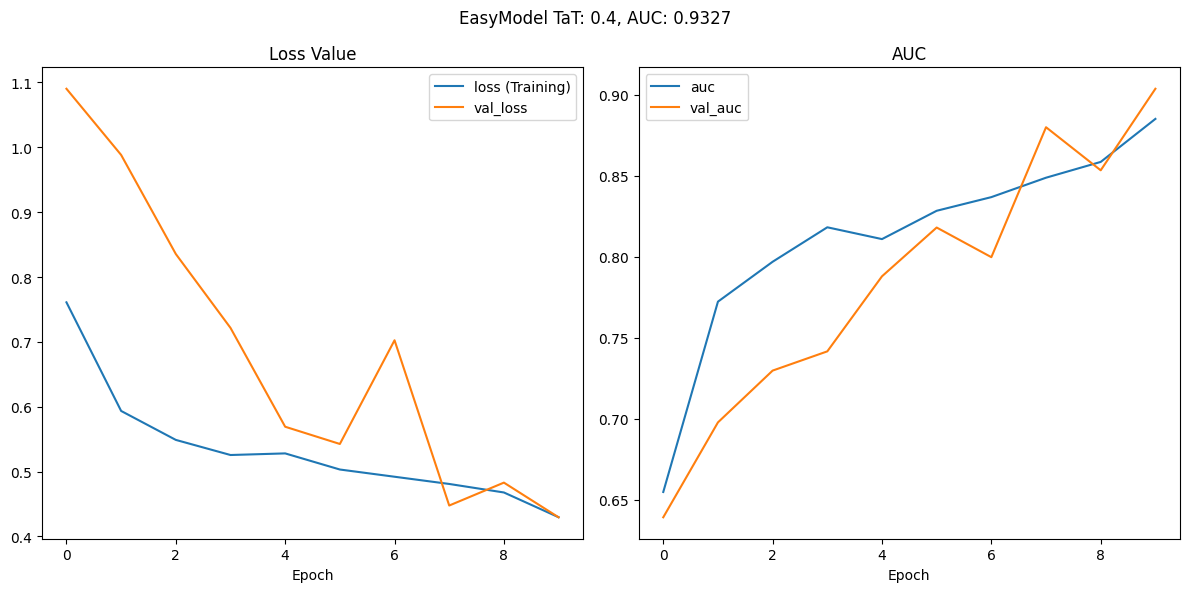

Train loss: 0.4296317398548126
Test val_loss: 0.42952507734298706
AUC: 0.9326670510602858
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.75      0.82       129
         1.0       0.78      0.92      0.84       121

    accuracy                           0.83       250
   macro avg       0.84      0.83      0.83       250
weighted avg       0.84      0.83      0.83       250



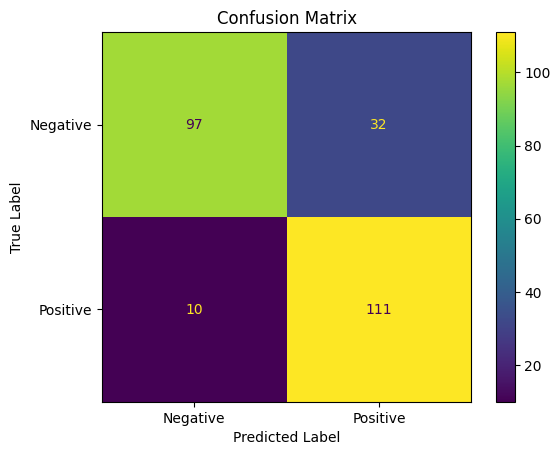

In [26]:
def build_ff_ann():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(800,)))
    model.add(BatchNormalization())  # Add batch normalization for better training stability
    model.add(Dropout(0.4))  # Add dropout for regularization
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification
    return model

model = build_ff_ann()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['auc'])  # Change metric to 'auc'
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot AUC
axs[1].plot(history.history["auc"], label="auc")
axs[1].plot(history.history["val_auc"], label="val_auc")
axs[1].set_title("AUC")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, AUC: {auc:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("AUC:", auc)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

# COMPLEX-BULKY FF-ANN

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,433 (1.17 MB)

 Trainable params: 305,153 (1.16 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.6239 - loss: 0.7797 - val_accuracy: 0.5280 - val_loss: 2.0101
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7100 - loss: 0.5588 - val_accuracy: 0.6200 - val_loss: 1.2933
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7494 - loss: 0.4820 - val_accuracy: 0.6680 - val_loss: 0.7873
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7448 - loss: 0.5184 - val_accuracy: 0.6840 - val_loss: 0.7955
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7296 - loss: 0.5094 - val_accuracy: 0.7520 - val_loss: 0.6470
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8094 - loss: 0.4448 - val_accuracy: 0.7360 - val_loss: 0.5670
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7746 - loss: 0.4855 - val_accuracy: 0.7360 - val_loss: 0.5587
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7530 - loss: 0.4837 - val_accuracy: 0.8200 - val_los

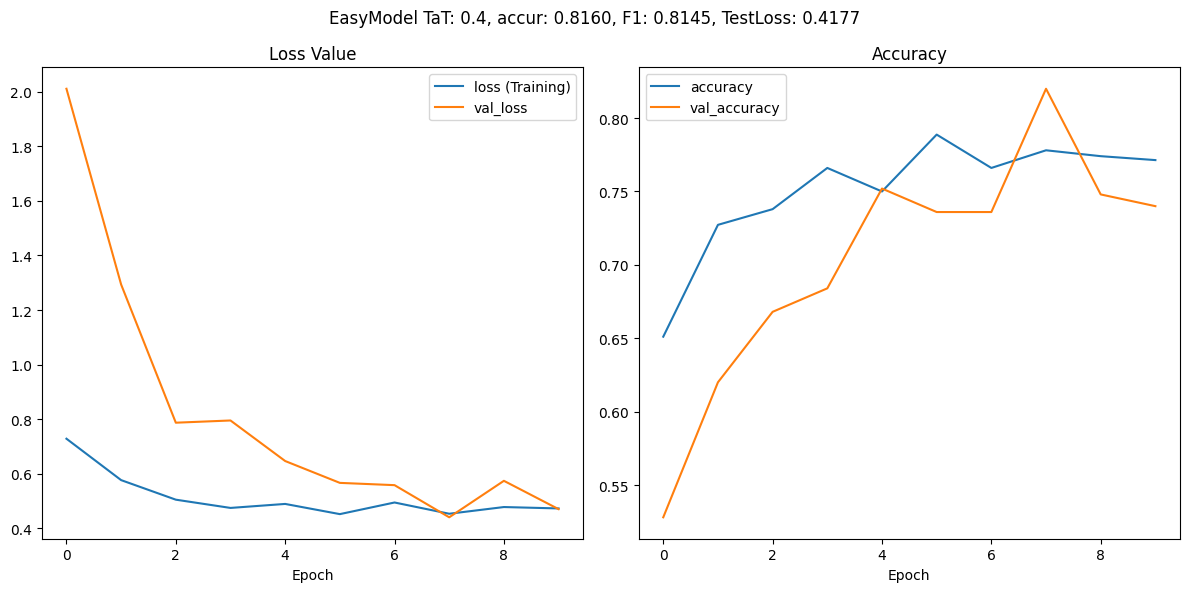

Train loss: 0.47342705726623535
Test val_loss: 0.4708235263824463
Train accuracy: 0.7713903784751892
Accuracy Score: 0.816
F1 Score: 0.8145161290322581
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.80      0.82       129
         1.0       0.80      0.83      0.81       121

    accuracy                           0.82       250
   macro avg       0.82      0.82      0.82       250
weighted avg       0.82      0.82      0.82       250



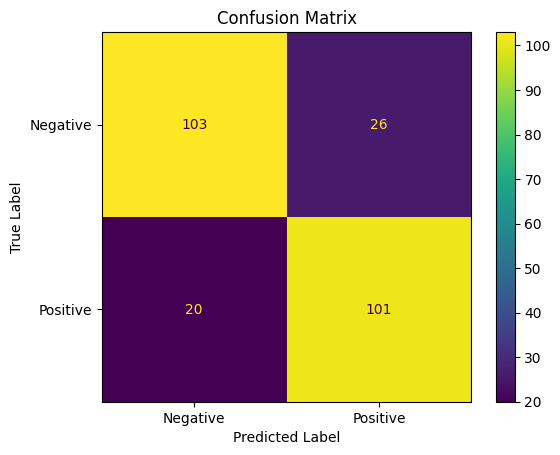

In [27]:
def build_ff_ann():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(800,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.1))  # Adding LeakyReLU activation with alpha=0.1
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification
    return model

model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1) # , callbacks=[tensorboard]

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - auc: 0.8751 - loss: 0.4526 - val_auc: 0.8149 - val_loss: 0.6134
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8876 - loss: 0.4267 - val_auc: 0.7610 - val_loss: 0.8164
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8981 - loss: 0.4064 - val_auc: 0.8775 - val_loss: 0.4781
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8693 - loss: 0.4671 - val_auc: 0.8060 - val_loss: 0.6636
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8795 - loss: 0.4408 - val_auc: 0.8649 - val_loss: 0.5005
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.8836 - loss: 0.4269 - val_auc: 0.8613 - val_loss: 0.5066
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8992 - loss: 0.4051 - val_auc: 0.8867 - val_loss: 0.4705
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8796 - loss: 0.4311 - val_auc: 0.8943 - val_loss: 0.4591
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9137 - loss

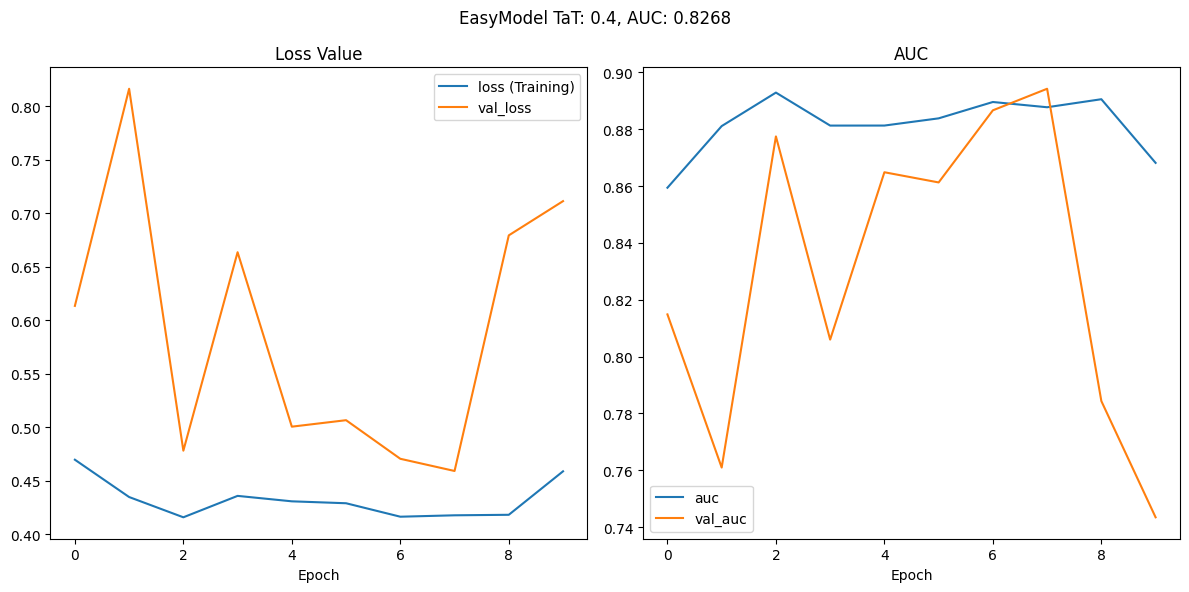

Train loss: 0.45877841114997864
Test val_loss: 0.7113717198371887
AUC: 0.8267666090076238
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.75      0.72       129
         1.0       0.71      0.64      0.67       121

    accuracy                           0.70       250
   macro avg       0.70      0.69      0.69       250
weighted avg       0.70      0.70      0.69       250



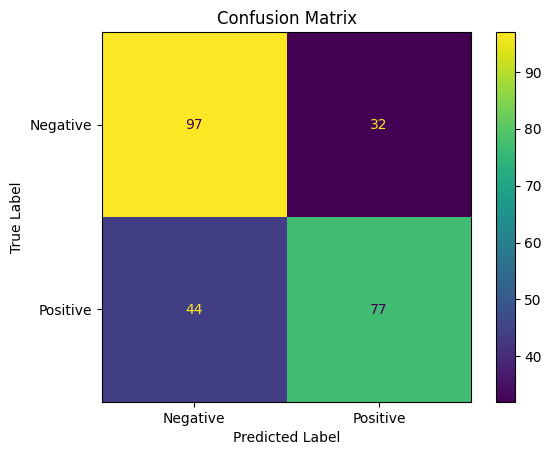

In [28]:
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['auc'])  # Change metric to 'auc'
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot AUC
axs[1].plot(history.history["auc"], label="auc")
axs[1].plot(history.history["val_auc"], label="val_auc")
axs[1].set_title("AUC")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, AUC: {auc:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("AUC:", auc)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

# BRANCHED ANN

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_83"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 800)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 256)       │    205,056 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 256)       │    205,056 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_53[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 128)       │    102,528 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 128)       │    102,528 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 256)       │          0 │ dense_61[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 128)       │          0 │ dense_55[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 128)       │          0 │ dense_57[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 64)        │     51,264 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 256)       │          0 │ leaky_re_lu_3[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 128)       │     32,896 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 64)        │      8,256 │ dropout_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 64)        │      8,256 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 32)        │      2,080 │ dense_59[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 64)        │     16,448 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 352)       │          0 │ dense_54[0][0],   │
│ (Concatenate)       │                   │            │ dense_56[0][0],   │
│                     │                   │            │ dense_58[0][0],   │
│                     │                   │            │ dense_60[0][0],   │
│                     │                   │            │ dense_62[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 352)       │      1,408 │ concatenate_1[0]… │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 759,457 (2.90 MB)

 Trainable params: 758,241 (2.89 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - accuracy: 0.5972 - loss: 0.7953 - val_accuracy: 0.6280 - val_loss: 1.6417
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6619 - loss: 0.6012 - val_accuracy: 0.6720 - val_loss: 1.4744
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7297 - loss: 0.5399 - val_accuracy: 0.6680 - val_loss: 1.0618
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7710 - loss: 0.4916 - val_accuracy: 0.6800 - val_loss: 0.7541
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7508 - loss: 0.4669 - val_accuracy: 0.7120 - val_loss: 0.6039
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8022 - loss: 0.3948 - val_accuracy: 0.7040 - val_loss: 0.6502
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7925 - loss: 0.4385 - val_accuracy: 0.7280 - val_loss: 0.5938
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7894 - loss: 0.4451 - val_accuracy: 0.7040 - val_lo

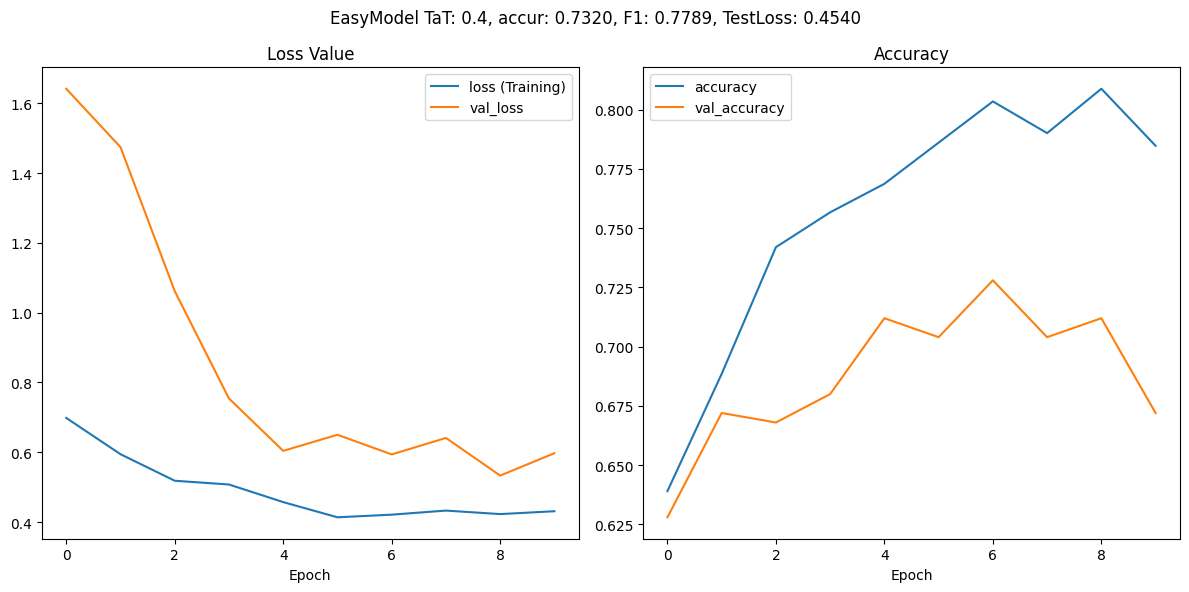

Train loss: 0.43093085289001465
Test val_loss: 0.5972059965133667
Train accuracy: 0.7847593426704407
Accuracy Score: 0.732
F1 Score: 0.7788778877887789
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.50      0.66       129
         1.0       0.65      0.98      0.78       121

    accuracy                           0.73       250
   macro avg       0.80      0.74      0.72       250
weighted avg       0.81      0.73      0.72       250



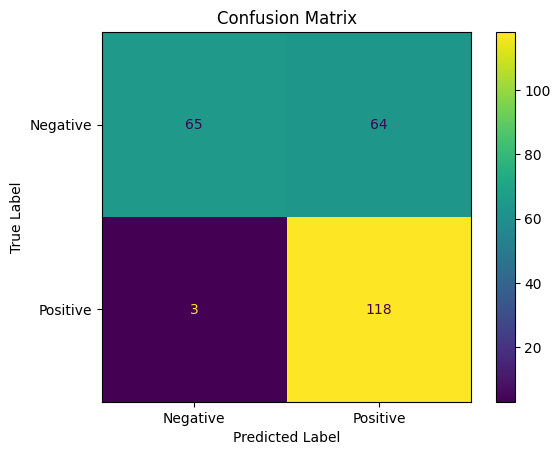

In [29]:
def build_ff_ann(input_shape=(800,)):
    input_layer = Input(shape=input_shape)
    
    # Branch 1
    branch1 = Dense(256, activation='relu')(input_layer)
    branch1 = BatchNormalization()(branch1)
    branch1 = Dropout(0.2)(branch1)
    branch1_output = Dense(128, activation='relu')(branch1)
    
    # Branch 2
    branch2 = Dense(128, activation='relu')(input_layer)
    branch2 = Dropout(0.2)(branch2)
    branch2_output = Dense(64, activation='relu')(branch2)
    
    # Branch 3
    branch3 = Dense(128, activation='relu')(input_layer)
    branch3 = Dropout(0.2)(branch3)
    branch3_output = Dense(64, activation='relu')(branch3)
    
    # Branch 4
    branch4 = Dense(64, activation='relu')(input_layer)
    branch4_output = Dense(32, activation='relu')(branch4)

    # Branch 5
    branch5 = Dense(256, kernel_initializer=GlorotUniform())(input_layer)
    branch5 = LeakyReLU(alpha=0.1)(branch5)
    branch5 = Dropout(0.2)(branch5)
    branch5_output = Dense(64, kernel_initializer=GlorotUniform(), activation='relu')(branch5)


    # Merge branches
    merged = concatenate([branch1_output, branch2_output, branch3_output, branch4_output, branch5_output])
    merged = BatchNormalization()(merged)
    merged = Dense(64, activation='relu')(merged)
    
    output_layer = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

model = build_ff_ann()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1) # , callbacks=[tensorboard]

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step - auc: 0.8532 - loss: 0.4854 - val_auc: 0.8447 - val_loss: 0.5770
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8859 - loss: 0.4305 - val_auc: 0.6902 - val_loss: 0.9583
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8932 - loss: 0.4141 - val_auc: 0.8839 - val_loss: 0.5048
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9422 - loss: 0.3120 - val_auc: 0.7681 - val_loss: 0.8592
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9224 - loss: 0.3530 - val_auc: 0.8664 - val_loss: 0.7542
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9045 - loss: 0.4039 - val_auc: 0.8014 - val_loss: 0.6726
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9157 - loss: 0.3710 - val_auc: 0.8327 - val_loss: 0.5599
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9017 - loss: 0.4054 - val_auc: 0.5686 - val_loss: 1.9203
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9109 - los

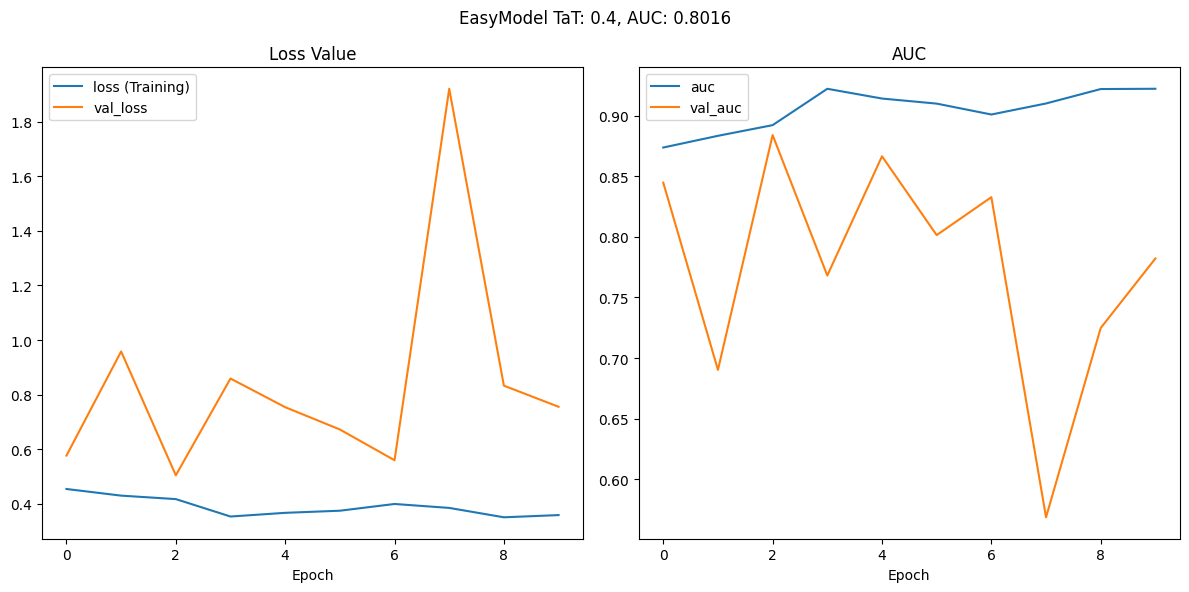

Train loss: 0.3590640723705292
Test val_loss: 0.7557293176651001
AUC: 0.8015888269588058
Classification Report:
               precision    recall  f1-score   support

         0.0       0.62      0.81      0.70       129
         1.0       0.70      0.46      0.56       121

    accuracy                           0.64       250
   macro avg       0.66      0.64      0.63       250
weighted avg       0.66      0.64      0.63       250



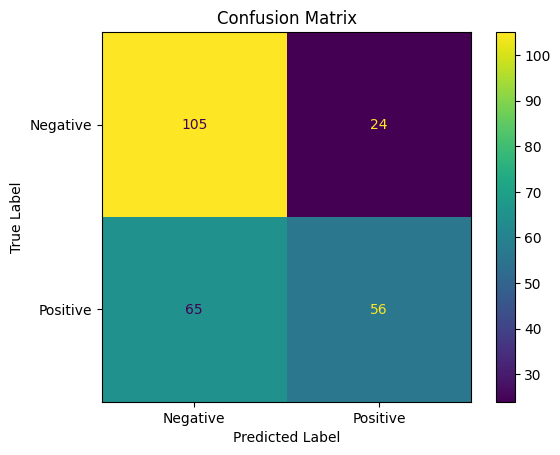

In [30]:
model.compile(optimizer=Adam(learning_rate=0.004), loss='binary_crossentropy', metrics=['auc'])  # Change metric to 'auc'
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot AUC
axs[1].plot(history.history["auc"], label="auc")
axs[1].plot(history.history["val_auc"], label="val_auc")
axs[1].set_title("AUC")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, AUC: {auc:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("AUC:", auc)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)